In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz
from scipy.optimize import curve_fit
from scipy.optimize import minimize

from tqdm import tqdm_notebook
from lmfit.models import VoigtModel
from tomoproc.util.npmath import discrete_cdf

The gaussian function is:

$$g(x) = \dfrac{A}{\sigma\sqrt{2\pi}}exp(\dfrac{-(x-\mu)^2}{2\sigma^2}),$$

where $A$ is the amplitude, $\mu$ is the mean (peak center), and $\sigma$ is the variance.

> The half-width at half-maximum (HWHM) for a gaussian distribution, $\alpha$, can be calculate with $$\alpha = \sigma\sqrt{2ln(2)}.$$

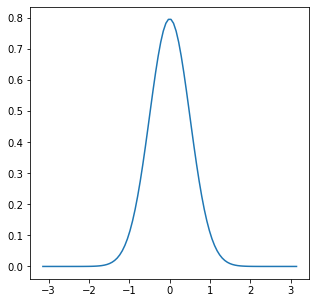

In [2]:
# functions

def gaussian(x, A, mu, sigma):
    return A/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/(sigma**2))


# quick test

x = np.linspace(-np.pi, np.pi, 100)

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(x, gaussian(x, 1, 0, 0.5))

The Lorentz function (a probability density function, PDF) is:

$$l(x) = \dfrac{1}{\pi\gamma} \dfrac{1}{1+(\dfrac{x-\mu}{\gamma})^2} ,$$

where $\mu$ is the mean (peak center) and $\gamma$ is the half-width at half-maximum (HWHM).

Since X-ray diffraction signal from detector is not a proper PDF, the function above need to be adjusted for peak fitting purpose, namely

$$l(x) = I \left[\dfrac{\gamma^2}{(x-\mu)^2 + \gamma^2} \right],$$

where $I$ is the height of the peak.

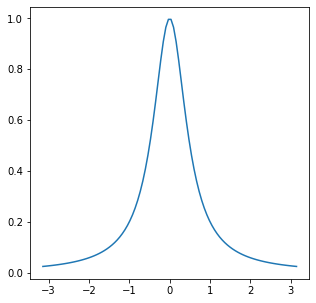

In [3]:
def lorentz(x, I, mu, gamma):
    return I*(gamma**2)/((x-mu)**2 + gamma**2)

# quick test
x = np.linspace(-np.pi, np.pi, 100)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(x, lorentz(x, 1, 0, 0.5))

The Voigt line profile is the convolution of a Gaussian profile, g(x;σ) and a Lorentzian profile, l(x;γ), 

$$v(x, A, \mu, \sigma, \gamma) = \int_{-\infty}^{+\infty} g(x, 1,\mu, \sigma) \: l(\mu-x, A, \mu, \gamma) dx.$$

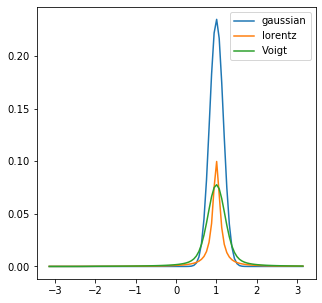

In [4]:
def voigt(x, A, mu, sigma, gamma):
    gg = gaussian(x,    1, mu, sigma)
    ll = lorentz(mu-x,  A*gamma, mu, gamma)
    return np.convolve(gg, ll, 'same')

# quick test
x = np.linspace(-np.pi, np.pi, 101)
A  = 0.1
mu = 1.0
alpha = 0.2
sigma = alpha/np.sqrt(2*np.log(2))
gamma = 0.1

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(x, gaussian(x, A, mu, sigma), label='gaussian')
ax.plot(x, lorentz( x, A, mu, gamma), label='lorentz')
ax.plot(x, voigt(   x, A, mu, sigma, gamma), label='Voigt')

ax.legend()

As pointed by [this post](https://stackoverflow.com/questions/53156135/wrong-voigt-output-convolution-with-asymmetric-x-input), convolution is expensive in terms of computation time which can get annoying when used as fit model. The following sample code does not need convolution.

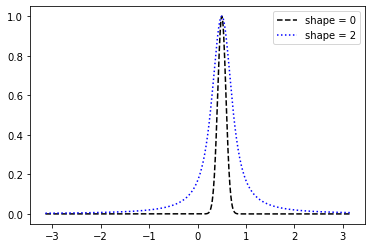

In [5]:
def voigt(x, amp, pos, fwhm, shape):
    tmp = 1/wofz(np.zeros((len(x))) +1j*np.sqrt(np.log(2.0))*shape).real
    return tmp*amp*wofz(2*np.sqrt(np.log(2.0))*(x-pos)/fwhm+1j*np.sqrt(np.log(2.0))*shape).real

x = np.linspace(-np.pi, np.pi, 1001)
y0 = voigt(x, 1, 0.5, 0.2, 0)
y1 = voigt(x, 1, 0.5, 0.2, 2)
plt.plot(x,y0,'k--',label='shape = 0')
plt.plot(x,y1,'b:', label='shape = 2')
plt.legend(loc=0)
plt.show()

Therefore, we should use the fast version above for peak fitting purpose.

Now, let's try to fit some 1D curves.

[1.04187419 2.00290082 0.07106849 2.29185662]
{'sigma': 0.05687740754375503, 'center': 2.0030428821171267, 'amplitude': 0.276136951482719, 'gamma': 0.05687740754375503}


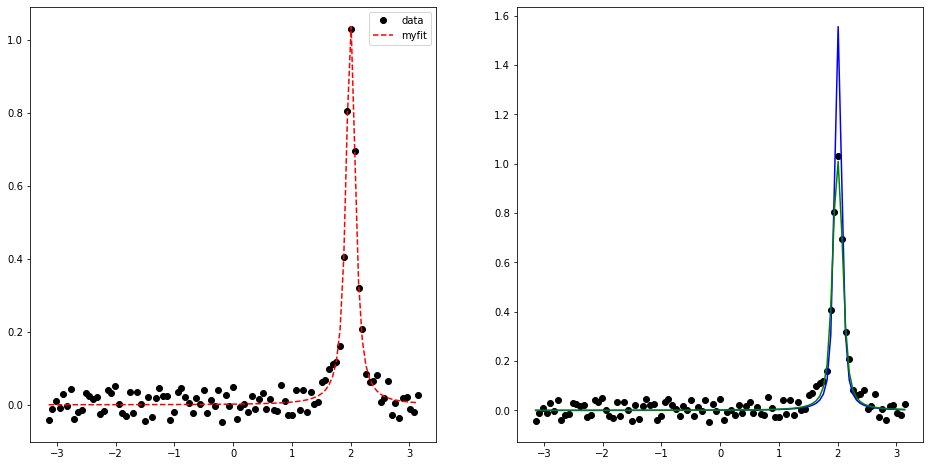

In [6]:
# generate synthetic signal
paras = [1, 2, 0.1, 1.5]
amp, pos, fwhm, shape = paras
N = 101
xdata = np.linspace(-np.pi, np.pi, N)
ydata = voigt(xdata, amp, pos, fwhm, shape) + (np.random.random(N)-0.5)*amp/10

popt, pcov = curve_fit(voigt, xdata, ydata, 
                       maxfev=int(1e6),
                       p0=[ydata.max(), xdata.mean(), 1, 1],
                       bounds=([0,              xdata.min(), 0,                       0],
                               [ydata.max()*10, xdata.max(), xdata.max()-xdata.min(), np.inf])
                      )

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(xdata, ydata, 'ko', label='data')
ax[0].plot(xdata, voigt(xdata, *popt), 'r--', label='myfit')
ax[0].legend()
print(popt)

from lmfit.models import VoigtModel
mod = VoigtModel()
pars = mod.guess(ydata, x=xdata)
out = mod.fit(ydata, pars, x=xdata)
ax[1].plot(xdata, ydata, 'ko', label='data')
ax[1].plot(xdata, out.init_fit, 'b-')
ax[1].plot(xdata, out.best_fit, 'g-')


print(out.best_values)

In [7]:
def myfit(xdata, ydata):
    popt, pcov = curve_fit(voigt, xdata, ydata, 
                           maxfev=int(1e6),
                           p0=[ydata.max(), xdata.mean(), 1, 1],
                           bounds=([0,              xdata.min(), 0,                       0],
                                   [ydata.max()*10, xdata.max(), xdata.max()-xdata.min(), np.inf]),
                          )
    return popt

def reffit(xdata, ydata):
    mod = VoigtModel()
    pars = mod.guess(ydata, x=xdata)
    out = mod.fit(ydata, pars, x=xdata)
    return out.best_values

In [8]:
dxc_myfit = []
dxc_lmfit = []

for i in tqdm_notebook(range(1000)):
    amp, pos, fwhm, shape = np.random.random(4)*np.pi
    N = 101
    xdata = np.linspace(-np.pi, np.pi, N)
    ydata = voigt(xdata, amp, pos, fwhm, shape) + (np.random.random(N)-0.5)*amp/10
    
    dxc_myfit.append(myfit(xdata, ydata)[1]-pos)
    dxc_lmfit.append(reffit(xdata, ydata)['center']-pos)


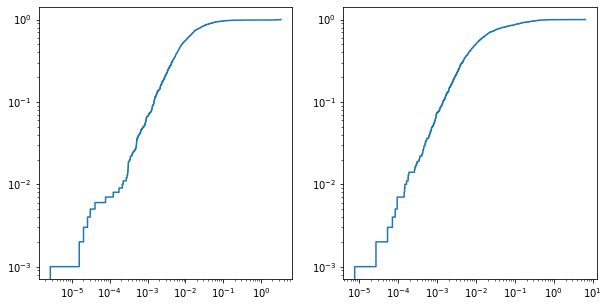

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

xx, yy = discrete_cdf(np.absolute(dxc_myfit))
ax[0].plot(xx, yy, label='myfit')
ax[0].set_yscale('log')
ax[0].set_xscale('log')


xx, yy = discrete_cdf(np.absolute(dxc_lmfit))
ax[1].plot(xx, yy, label='lmfit')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

In [19]:
amp, pos, fwhm, shape = np.random.random(4)*np.pi
N = 101
xdata = np.linspace(-np.pi, np.pi, N)
ydata = voigt(xdata, amp, pos, fwhm, shape) + (np.random.random(N)-0.5)*amp/10

In [20]:
%timeit x = myfit(xdata, ydata)

14.5 ms ± 609 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit x = reffit(xdata, ydata)

12.2 ms ± 86.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
